In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
final_dataset_featured=pd.read_csv('final_train.csv')

Final touch to model

We will first need to drop the provider column and then make the training data. Also, we need to scale the dataset

In [4]:
Training_Label=final_dataset_featured['Provider']
Training_Final=final_dataset_featured.drop(columns='Provider',axis=1)

In [5]:
Training_Final.shape

(5281, 310)

In [6]:
Training_Final.columns

Index(['PotentialFraud', 'InscClaimAmtReimbursed', 'DeductibleAmtPaid',
       'Hospitalization_Duration', 'Claim_Period', 'ExtraClaimDays',
       'is_admitted', 'RenalDiseaseIndicator', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov',
       ...
       'PerProviderClmDiagnosisCode_8_count_ClaimID',
       'PerProviderClmDiagnosisCode_9_count_ClaimID',
       'PerProviderClmDiagnosisCode_10_count_ClaimID',
       'PerProviderDiagnosisGroupCode_count_ClaimID', 'Gender_0', 'Gender_1',
       'Race_1', 'Race_2', 'Race_3', 'Race_5'],
      dtype='object', length=310)

In [7]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
Training_Final.isnull().sum()

PotentialFraud                                            0
InscClaimAmtReimbursed                                    0
DeductibleAmtPaid                                         0
Hospitalization_Duration                                  0
Claim_Period                                              0
ExtraClaimDays                                            0
is_admitted                                               0
RenalDiseaseIndicator                                     0
NoOfMonths_PartACov                                       0
NoOfMonths_PartBCov                                       0
ChronicCond_Alzheimer                                     0
ChronicCond_Heartfailure                                  0
ChronicCond_KidneyDisease                                 0
ChronicCond_Cancer                                        0
ChronicCond_ObstrPulmonary                                0
ChronicCond_Depression                                    0
ChronicCond_Diabetes                    

In [8]:
y = Training_Final['PotentialFraud']
X = Training_Final.drop('PotentialFraud', axis=1)

In [31]:
##Split the trainng and testing dataset
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.2, random_state=42)

StandardScaler

In [32]:
from sklearn.preprocessing import StandardScaler

def apply_standard_scaler(X_train, X_test=None):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)

    if X_test is not None:
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled

    return X_train_scaled


In [33]:
X_train_scaled, X_test_scaled = apply_standard_scaler(X_train, X_test)


array([[-0.20949684, -0.23640071, -0.16660238, ..., -0.30344911,
        -0.17354415, -0.19644047],
       [-0.23266248, -0.18399734, -0.22606652, ..., -0.30344911,
        -0.09427831,  0.10225087],
       [-0.35102737, -0.31822352, -0.30931633, ..., -0.36134031,
        -0.17354415, -0.19644047],
       ...,
       [ 0.42295142,  0.26028211,  0.20802174, ...,  0.10178928,
        -0.01501247, -0.19644047],
       [-0.3493487 , -0.31822352, -0.30931633, ..., -0.36134031,
        -0.17354415, -0.19644047],
       [-0.34158952, -0.31822352, -0.30931633, ..., -0.24555791,
        -0.09427831, -0.19644047]])

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

def get_threshold_fpr_tpr(y, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
    return fpr, tpr, thresholds

def draw_ROC_AUC_plot(train_fpr, train_tpr, test_fpr, test_tpr):
    plt.plot(train_fpr, train_tpr, label="Train AUC = " + str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="Test AUC = " + str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid()
    plt.show()

def find_best_threshold(thresholds, fpr, tpr):
    t = thresholds[np.argmax(tpr * (1 - fpr))]
    print("The maximum value of tpr*(1-fpr)", max(tpr * (1 - fpr)), "for threshold", np.round(t, 3))
    return t

def predict_with_best_threshold(proba, threshold):
    predictions = []
    for i in proba:
        if i >= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

def get_confusion_matrix(y, y_pred,axis, best_t):
    cm = pd.DataFrame(confusion_matrix(y, predict_with_best_threshold(y_pred, best_t)))
    sns.heatmap(cm, annot = True, fmt= 'd',annot_kws={"size": 15}, xticklabels= ['Predicted No', 'Predicted Yes'], yticklabels= ['Actaual No','Actual Yes'],ax=axis)



In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

In [13]:
###UTILITY FUNCTIONS
def model_performance_check(model,X_train,X_test,y_train,y_test):

    y_train_pred = model.predict_proba(X_train)[:,1]
    y_test_pred = model.predict_proba(X_test)[:,1]

    train_fpr, train_tpr, tr_thresholds = get_threshold_fpr_tpr(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = get_threshold_fpr_tpr(y_test, y_test_pred)

    #plot Roc_AUC_curve
    draw_ROC_AUC_plot(train_fpr, train_tpr,test_fpr, test_tpr)

    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

    #draw confusion matrix
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

    #training confusion matrix heatmap
    get_confusion_matrix(y_train, y_train_pred,ax[0], best_t)
    ax[0].set_title("confusion matrix for traning data")

    #test confusion matrix heatmap
    get_confusion_matrix(y_test, y_test_pred,ax[1], best_t)
    ax[1].set_title("confusion matrix for test data")

    actual_output = y_test
    pred_output = predict_with_best_threshold(y_test_pred, best_t)

    model_f1_score = metrics.f1_score(actual_output,pred_output)
    print("Model test F1 score is : ",model_f1_score)

    model_AUC_score = metrics.auc(test_fpr, test_tpr)
    print("Model test AUC score is : ",model_AUC_score)

    return (model_f1_score, model_AUC_score)

RANDOM FOREST CLASSIFIER

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

RF = RandomForestClassifier(class_weight = 'balanced', random_state=42)

param_grid = {
    'n_estimators': [300, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
    

RF_CV = GridSearchCV(estimator=RF, param_grid=param_grid, cv= 5,scoring='roc_auc', n_jobs=-1, return_train_score=True, verbose=10)
RF_CV.fit(X_train_scaled, y_train)

print("tuned hpyerparameters :(best parameters) ",RF_CV.best_params_)
print("roc_auc :",RF_CV.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 500}
roc_auc : 0.9367391008400021


In [35]:
RF2 = RandomForestClassifier(n_estimators = 500,max_features='auto',max_depth=4,criterion='entropy',
                             class_weight = 'balanced',n_jobs=-1,verbose=10, random_state=42)

RF2=RF2.fit(X_train_scaled,y_train)
print("score",RF2.score(X_test_scaled,y_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.1s


building tree 1 of 500building tree 2 of 500

building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s


building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    0.5s


building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.7s


building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500


[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.0s


building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500


[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    1.2s


building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500
building tree 202 of 500
building tree 203 of 500
building tree 204 of 500
building tree 205 of 500
building tree 206 of 500
building tree 207 of 500
building tree 208 of 500
building tree 209 of 500


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.5s


building tree 210 of 500
building tree 211 of 500
building tree 212 of 500
building tree 213 of 500
building tree 214 of 500
building tree 215 of 500
building tree 216 of 500
building tree 217 of 500
building tree 218 of 500
building tree 219 of 500


[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    1.7s


building tree 220 of 500
building tree 221 of 500
building tree 222 of 500
building tree 223 of 500
building tree 224 of 500
building tree 225 of 500
building tree 226 of 500
building tree 227 of 500
building tree 228 of 500
building tree 229 of 500
building tree 230 of 500
building tree 231 of 500
building tree 232 of 500
building tree 233 of 500
building tree 234 of 500
building tree 235 of 500
building tree 236 of 500
building tree 237 of 500
building tree 238 of 500
building tree 239 of 500
building tree 240 of 500


[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:    2.2s


building tree 241 of 500
building tree 242 of 500
building tree 243 of 500
building tree 244 of 500
building tree 245 of 500
building tree 246 of 500
building tree 247 of 500
building tree 248 of 500
building tree 249 of 500
building tree 250 of 500
building tree 251 of 500
building tree 252 of 500
building tree 253 of 500
building tree 254 of 500
building tree 255 of 500
building tree 256 of 500
building tree 257 of 500
building tree 258 of 500
building tree 259 of 500
building tree 260 of 500
building tree 261 of 500
building tree 262 of 500
building tree 263 of 500
building tree 264 of 500
building tree 265 of 500
building tree 266 of 500
building tree 267 of 500
building tree 268 of 500
building tree 269 of 500
building tree 270 of 500
building tree 271 of 500
building tree 272 of 500
building tree 273 of 500
building tree 274 of 500
building tree 275 of 500
building tree 276 of 500
building tree 277 of 500
building tree 278 of 500
building tree 279 of 500
building tree 280 of 500


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    2.5s


building tree 281 of 500
building tree 282 of 500
building tree 283 of 500
building tree 284 of 500
building tree 285 of 500
building tree 286 of 500
building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500


[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:    2.8s


building tree 318 of 500building tree 319 of 500

building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500
building tree 327 of 500
building tree 328 of 500
building tree 329 of 500
building tree 330 of 500
building tree 331 of 500
building tree 332 of 500
building tree 333 of 500
building tree 334 of 500
building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500


[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    3.1s


building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    3.3s


building tree 363 of 500building tree 364 of 500
building tree 365 of 500

building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500


[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    3.6s


building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500


[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:    3.9s


building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500
building tree 443 of 500
building tree 444 of 500
building tree 445 of 500
building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500


[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    4.2s


building tree 451 of 500
building tree 452 of 500
building tree 453 of 500
building tree 454 of 500
building tree 455 of 500
building tree 456 of 500
building tree 457 of 500
building tree 458 of 500
building tree 459 of 500
building tree 460 of 500
building tree 461 of 500
building tree 462 of 500
building tree 463 of 500
building tree 464 of 500
building tree 465 of 500
building tree 466 of 500
building tree 467 of 500
building tree 468 of 500
building tree 469 of 500
building tree 470 of 500
building tree 471 of 500
building tree 472 of 500
building tree 473 of 500
building tree 474 of 500
building tree 475 of 500
building tree 476 of 500
building tree 477 of 500
building tree 478 of 500
building tree 479 of 500
building tree 480 of 500
building tree 481 of 500
building tree 482 of 500
building tree 483 of 500
building tree 484 of 500
building tree 485 of 500
building tree 486 of 500


[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:    4.5s


building tree 487 of 500
building tree 488 of 500
building tree 489 of 500
building tree 490 of 500
building tree 491 of 500
building tree 492 of 500
building tree 493 of 500
building tree 494 of 500
building tree 495 of 500
building tree 496 of 500
building tree 497 of 500
building tree 498 of 500
building tree 499 of 500
building tree 500 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    

score 0.8637653736991485


[Parallel(n_jobs=8)]: Done 297 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 322 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 376 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 405 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 465 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Para

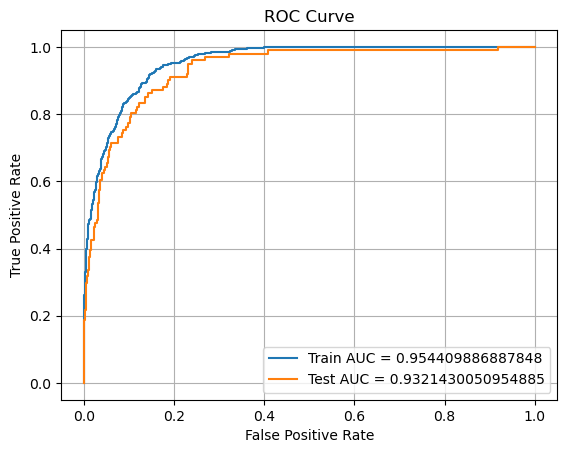

The maximum value of tpr*(1-fpr) 0.7844985598324169 for threshold 0.416
Model test F1 score is :  0.49438202247191015
Model test AUC score is :  0.9321430050954885


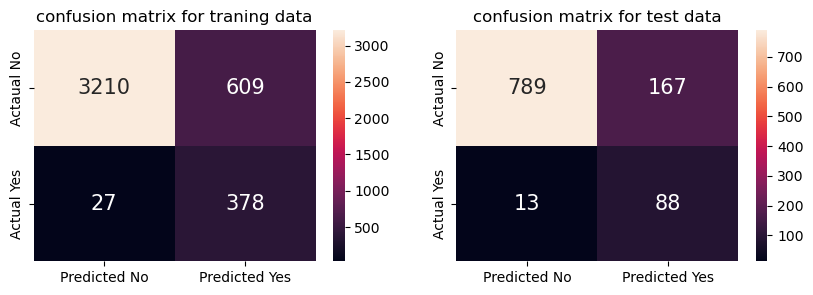

In [36]:
model_f1_score, model_AUC_score = model_performance_check(RF2,X_train_scaled,X_test_scaled,y_train,y_test)

LOGISTIC REGRESSION

In [37]:
grid={"C":np.logspace(-3,3,7), "penalty":['l2','none']}

logreg=LogisticRegression(max_iter=500)
logreg_cv=GridSearchCV(logreg,grid,cv=10,  n_jobs=-1, return_train_score=True)
logreg_cv.fit(X_train_scaled,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)


tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2'}
accuracy : 0.9367903599878995


In [38]:
logreg2=LogisticRegression(C=1.0,penalty="l2")
logreg2.fit(X_train_scaled,y_train)
print("score",logreg2.score(X_test_scaled,y_test))

score 0.9318826868495743


c:\Users\jhauj\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


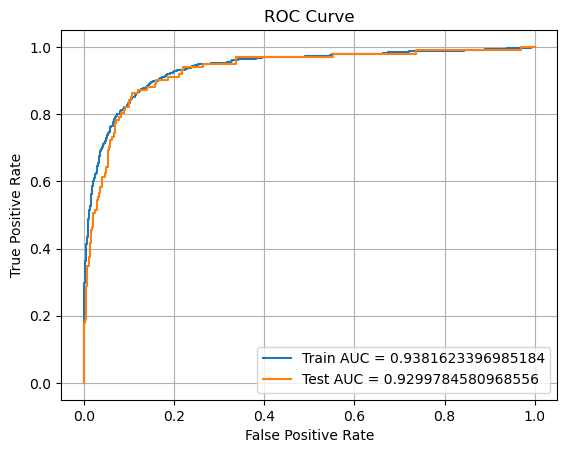

The maximum value of tpr*(1-fpr) 0.7636980788067459 for threshold 0.059
Model test F1 score is :  0.5493827160493827
Model test AUC score is :  0.9299784580968556


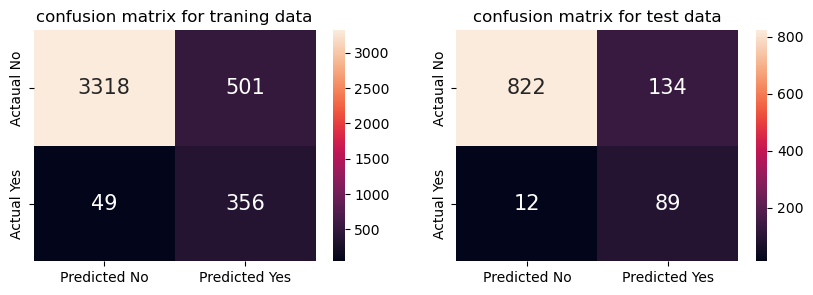

In [39]:
model_f1_score, model_AUC_score = model_performance_check(logreg2,X_train_scaled,X_test_scaled,y_train,y_test)

In [29]:
def model_comp(label=[],metric1=[],metric2=[],set_ylabel='',set_title='',metric1_label='',metric2_label=''):

    x = np.arange(len(model))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12,5))
    rects1 = ax.bar(x - width/2, metric1, width, label=metric1_label,color = 'teal')
    rects2 = ax.bar(x + width/2, metric2, width, label=metric2_label)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(set_ylabel)
    ax.set_title(set_title)
    ax.set_xticks(x)
    ax.set_xticklabels(model)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

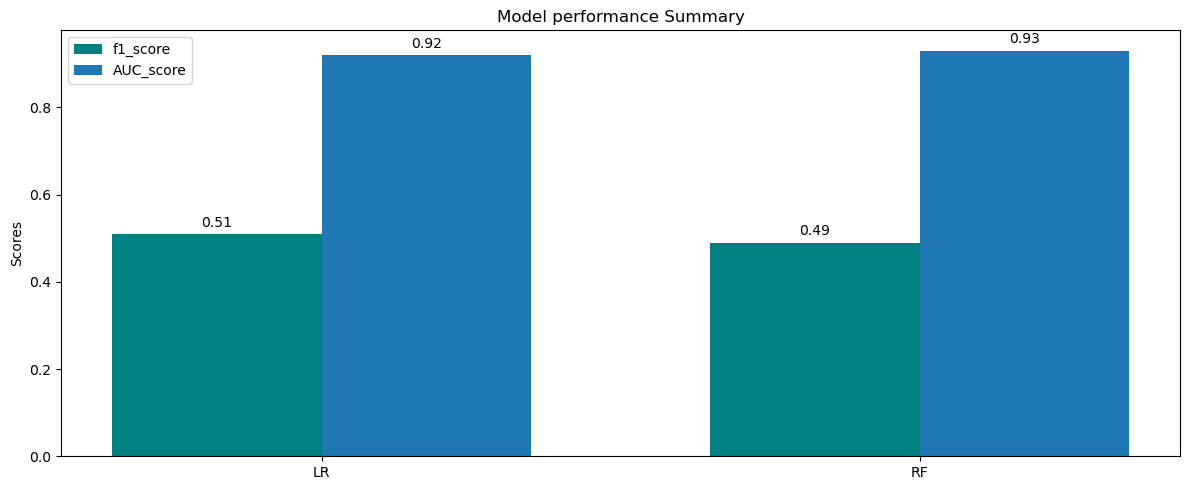

In [76]:
model = ['LR','RF']
f1_score = [0.51,0.49]
AUC_score = [0.92,0.93]

model_comp(model,f1_score,AUC_score,'Scores','Model performance Summary','f1_score','AUC_score')

FEATURE SELECTION USING FEATURE IMPORTANCE


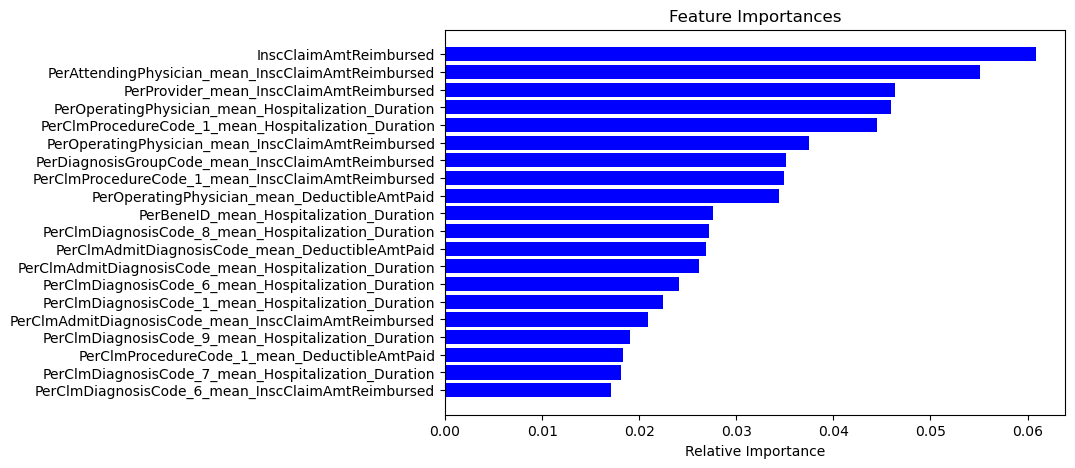

In [57]:
#for random  forest classifier

features =X.columns
importances = RF2.feature_importances_
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(8,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig('feature.png')
plt.show()


In [65]:
column_names = ['PerClmDiagnosisCode_6_mean_InscClaimAmtReimbursed',
'PerClmDiagnosisCode_7_mean_Hospitalization_Duration',
'PerClmProcedureCode_1_mean_DeductibleAmtPaid',
'PerClmDiagnosisCode_9_mean_Hospitalization_Duration',
'PerClmAdmitDiagnosisCode_mean_InscClaimAmtReimbursed',
'PerClmDiagnosisCode_1_mean_Hospitalization_Duration',
'PerClmDiagnosisCode_6_mean_Hospitalization_Duration',
'PerClmAdmitDiagnosisCode_mean_Hospitalization_Duration',
'PerClmAdmitDiagnosisCode_mean_DeductibleAmtPaid',
'PerClmDiagnosisCode_8_mean_Hospitalization_Duration',
'PerBeneID_mean_Hospitalization_Duration',
'PerOperatingPhysician_mean_DeductibleAmtPaid',
'PerClmProcedureCode_1_mean_InscClaimAmtReimbursed',
'PerDiagnosisGroupCode_mean_InscClaimAmtReimbursed',
'PerOperatingPhysician_mean_InscClaimAmtReimbursed',
'PerClmProcedureCode_1_mean_Hospitalization_Duration',
'PerOperatingPhysician_mean_Hospitalization_Duration',
'PerProvider_mean_InscClaimAmtReimbursed',
'PerAttendingPhysician_mean_InscClaimAmtReimbursed',
'InscClaimAmtReimbursed']

In [66]:
column_indices = [X_train.columns.get_loc(name) for name in column_names]

In [67]:
X_train1 = X_train_scaled[:, column_indices]
X_test1 = X_test_scaled[:, column_indices]

In [68]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(class_weight = 'balanced', random_state=42)

param_grid = {
    'n_estimators': [300, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}


RF_CV = GridSearchCV(estimator=RF, param_grid=param_grid, cv= 5,scoring='roc_auc', n_jobs=-1, return_train_score=True, verbose=10)
RF_CV.fit(X_train1, y_train)

print("tuned hpyerparameters :(best parameters) ",RF_CV.best_params_)
print("roc_auc :",RF_CV.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 500}
roc_auc : 0.9387042581592432


In [69]:
RF2 = RandomForestClassifier(n_estimators = 500,max_features='auto',max_depth=5,criterion='entropy',
                             class_weight = 'balanced',n_jobs=-1,verbose=1, random_state=42)

RF2=RF2.fit(X_train1,y_train)

print("score",RF2.score(X_test1,y_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


score 0.8741721854304636


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


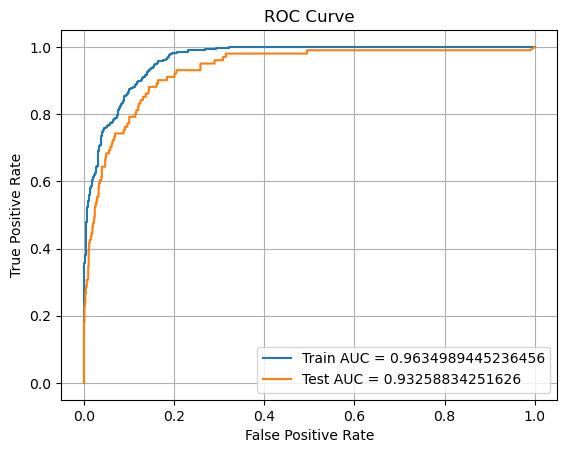

The maximum value of tpr*(1-fpr) 0.8014896278839719 for threshold 0.35
Model test F1 score is :  0.4906666666666667
Model test AUC score is :  0.93258834251626


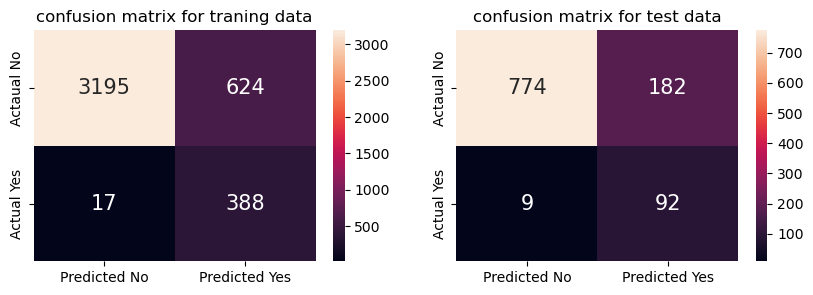

In [70]:
model_f1_score, model_AUC_score = model_performance_check(RF2,X_train1,X_test1,y_train,y_test)

LOGISTIC REGRESSION

In [72]:
grid={"C":np.logspace(-3,3,7), "penalty":['l2','none']}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10,  n_jobs=-1, return_train_score=True)
logreg_cv.fit(X_train1,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)


tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2'}
accuracy : 0.9341848453273279


In [73]:
logreg2=LogisticRegression(C=0.01,penalty='l2')
logreg2.fit(X_train1,y_train)
print("score",logreg2.score(X_test1,y_test))

score 0.9280983916745507


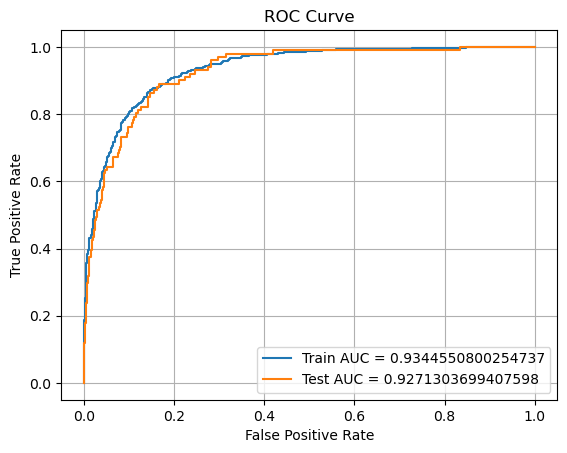

The maximum value of tpr*(1-fpr) 0.7431122490213002 for threshold 0.062
Model test F1 score is :  0.5176470588235295
Model test AUC score is :  0.9271303699407598


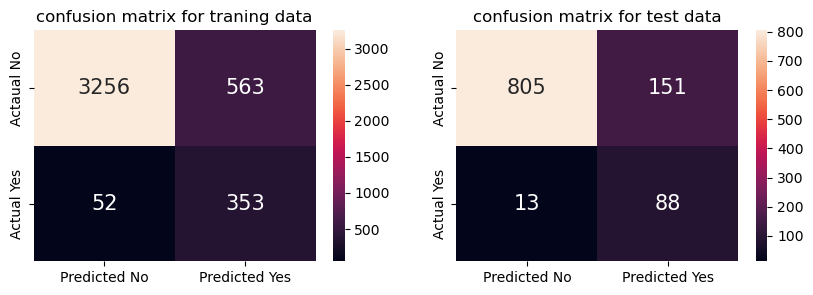

In [74]:
model_f1_score, model_AUC_score = model_performance_check(logreg2,X_train1,X_test1,y_train,y_test)

USING ANOTHER ALGORITHM-XGBOOST ALGORITHM

In [77]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import xgboost as xgb

XGB = xgb.XGBClassifier()

parameters = {"eta" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3] , "n_estimators" : [5,10,50, 75, 100]}

XGB_CV = GridSearchCV(
    XGB, 
    parameters , 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1,
    return_train_score=True, 
    verbose=10
    )
XGB_CV.fit(X_train_scaled,y_train)

print("tuned hpyerparameters :(best parameters) ",XGB_CV.best_params_)
print("roc_auc :",XGB_CV.best_score_)






Fitting 5 folds for each of 30 candidates, totalling 150 fits
tuned hpyerparameters :(best parameters)  {'eta': 0.1, 'n_estimators': 75}
roc_auc : 0.9356823187474674


In [78]:
XGB2 = xgb.XGBClassifier(eta=0.1,n_estimators=75,n_jobs=-1)

XGB2=XGB2.fit(X_train_scaled,y_train)

print("score",XGB2.score(X_test_scaled,y_test))

score 0.9252601702932829


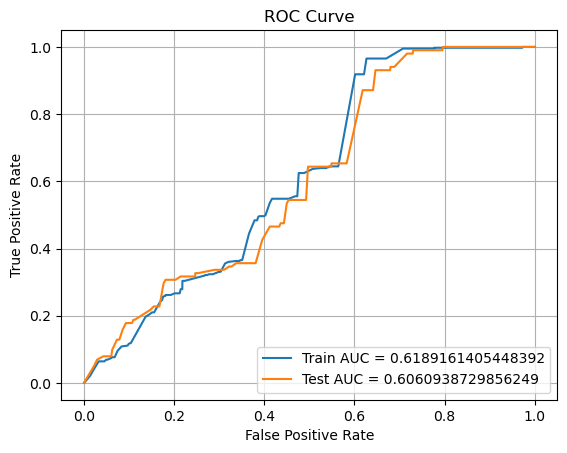

The maximum value of tpr*(1-fpr) 0.3660605355289827 for threshold 0.982
Model test F1 score is :  0.22564102564102564
Model test AUC score is :  0.6060938729856249


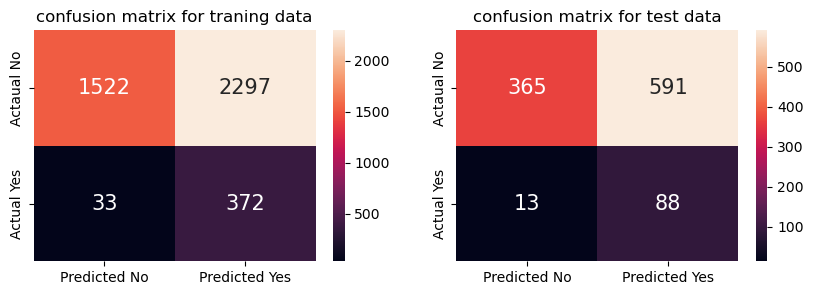

In [80]:
model_f1_score, model_AUC_score = model_performance_check(XGB2,X_train,X_test,y_train,y_test)